In [ ]:
# Notebook 2 — Binary CNN
# Colab-ready. Run top-to-bottom.

# 0) Install / imports (no TF reinstall — use environment's TF)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))



TensorFlow: 2.19.0
GPU devices: []


In [ ]:
# 1) GPU safety (prevent TF from grabbing all GPU memory)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled memory growth on GPU(s).")
    except Exception as e:
        print("Could not set memory growth:", e)



In [ ]:
# 2) Config — update paths if needed
IMAGE_FOLDER = "/content/drive/MyDrive/HAM10000_images"   # images folder created by Notebook 1
SPLITS_DIR = "/content/drive/MyDrive/splits"              # output from Notebook 1
OUTPUT_DIR = "/content/drive/MyDrive/models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
RANDOM_STATE = 42



In [ ]:
!ls "/content/drive/"

MyDrive


In [ ]:
!find /content/drive -type f -name "df_train.csv"
!find /content/drive -type f -name "df_val.csv"
!find /content/drive -type f -name "df_test.csv"


/content/drive/MyDrive/splits/df_train.csv
find: ‘/content/drive/.Encrypted/.shortcut-targets-by-id/19yW7TGX_Vp0hUeRMOwiNV98lD4Wp6rwj/GSoC Sample Proposals (Youtube)’: No such file or directory
find: ‘/content/drive/.Encrypted/.shortcut-targets-by-id/1jR1HtHp_VQ23c56by0YFWmFpiNHpulKn/CS2206-Slides’: No such file or directory
/content/drive/MyDrive/splits/df_val.csv
find: ‘/content/drive/.Encrypted/.shortcut-targets-by-id/19yW7TGX_Vp0hUeRMOwiNV98lD4Wp6rwj/GSoC Sample Proposals (Youtube)’: No such file or directory
find: ‘/content/drive/.Encrypted/.shortcut-targets-by-id/1jR1HtHp_VQ23c56by0YFWmFpiNHpulKn/CS2206-Slides’: No such file or directory
/content/drive/MyDrive/splits/df_test.csv
find: ‘/content/drive/.Encrypted/.shortcut-targets-by-id/19yW7TGX_Vp0hUeRMOwiNV98lD4Wp6rwj/GSoC Sample Proposals (Youtube)’: No such file or directory
find: ‘/content/drive/.Encrypted/.shortcut-targets-by-id/1jR1HtHp_VQ23c56by0YFWmFpiNHpulKn/CS2206-Slides’: No such file or directory


In [ ]:
# 3) Load CSV splits (Notebook 1 must have created these)
df_train = pd.read_csv(os.path.join(SPLITS_DIR, "df_train.csv"))
df_val   = pd.read_csv(os.path.join(SPLITS_DIR, "df_val.csv"))
df_test  = pd.read_csv(os.path.join(SPLITS_DIR, "df_test.csv"))

# If Notebook1 saved oversampled train as df_train.csv then use it directly; else adapt accordingly.
print("Train rows:", len(df_train), "Val rows:", len(df_val), "Test rows:", len(df_test))



Train rows: 29491 Val rows: 861 Test rows: 1780


In [ ]:
# 4) Ensure we have file paths in CSVs (if not present, create)
for d in [df_train, df_val, df_test]:
    if 'filepath' not in d.columns:
        d['filename'] = d['image_id'].astype(str) + '.jpg'
        d['filepath'] = d['filename'].apply(lambda x: os.path.join(IMAGE_FOLDER, x))



In [ ]:
# 5) Build binary label column if not present (benign vs malignant mapping used in your code)
benign_classes = ['bkl', 'df', 'nv', 'vasc']
for df in [df_train, df_val, df_test]:
    if 'binary_label' not in df.columns:
        df['binary_label'] = df['dx'].apply(lambda x: 'benign' if x in benign_classes else 'malignant')

print("Example binary label counts (train):\n", df_train['binary_label'].value_counts())



Example binary label counts (train):
 binary_label
benign       16852
malignant    12639
Name: count, dtype: int64


In [ ]:
# 6) Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_flow = train_datagen.flow_from_dataframe(
    df_train, x_col='filepath', y_col='binary_label',
    target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb',
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True
)

val_flow = val_datagen.flow_from_dataframe(
    df_val, x_col='filepath', y_col='binary_label',
    target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb',
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

test_flow = test_datagen.flow_from_dataframe(
    df_test, x_col='filepath', y_col='binary_label',
    target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb',
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)



Found 29491 validated image filenames belonging to 2 classes.
Found 861 validated image filenames belonging to 2 classes.
Found 1780 validated image filenames belonging to 2 classes.


In [ ]:
# 7) Build Binary CNN model (matches your architecture but with Input & BatchNorm)
def build_binary_cnn(input_shape=(IMG_SIZE,IMG_SIZE,3)):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3,3), activation='relu', padding='valid'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

binary_model = build_binary_cnn()
binary_model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,114 (42.61 MB)

 Trainable params: 11,169,666 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# 8) Callbacks and checkpoint
checkpoint_path = os.path.join(OUTPUT_DIR, "binary_cnn_best.h5")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

# 9) Train
history = binary_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS,
    callbacks=callbacks
)




/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6624 - loss: 1.2558
Epoch 1: val_loss improved from inf to 0.53531, saving model to /content/drive/MyDrive/models/binary_cnn_best.h5


922/922 ━━━━━━━━━━━━━━━━━━━━ 4620s 5s/step - accuracy: 0.6624 - loss: 1.2554 - val_accuracy: 0.7840 - val_loss: 0.5353 - learning_rate: 1.0000e-04
Epoch 2/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7455 - loss: 0.5958
Epoch 2: val_loss improved from 0.53531 to 0.48080, saving model to /content/drive/MyDrive/models/binary_cnn_best.h5


922/922 ━━━━━━━━━━━━━━━━━━━━ 4320s 5s/step - accuracy: 0.7455 - loss: 0.5958 - val_accuracy: 0.8328 - val_loss: 0.4808 - learning_rate: 1.0000e-04
Epoch 3/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7715 - loss: 0.4911
Epoch 3: val_loss did not improve from 0.48080
922/922 ━━━━━━━━━━━━━━━━━━━━ 4368s 5s/step - accuracy: 0.7715 - loss: 0.4911 - val_accuracy: 0.8490 - val_loss: 0.5041 - learning_rate: 1.0000e-04
Epoch 4/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7855 - loss: 0.4569
Epoch 4: val_loss did not improve from 0.48080
922/922 ━━━━━━━━━━━━━━━━━━━━ 4355s 5s/step - accuracy: 0.7856 - loss: 0.4569 - val_accuracy: 0.7991 - val_loss: 1.0289 - learning_rate: 1.0000e-04
Epoch 5/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7918 - loss: 0.4417
Epoch 5: val_loss improved from 0.48080 to 0.41709, saving model to /content/drive/MyDrive/models/binary_cnn_best.h5


922/922 ━━━━━━━━━━━━━━━━━━━━ 4209s 5s/step - accuracy: 0.7918 - loss: 0.4417 - val_accuracy: 0.8467 - val_loss: 0.4171 - learning_rate: 1.0000e-04
Epoch 6/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8088 - loss: 0.4128
Epoch 6: val_loss did not improve from 0.41709
922/922 ━━━━━━━━━━━━━━━━━━━━ 4145s 4s/step - accuracy: 0.8088 - loss: 0.4127 - val_accuracy: 0.8374 - val_loss: 0.5004 - learning_rate: 1.0000e-04
Epoch 7/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8150 - loss: 0.3842
Epoch 7: val_loss did not improve from 0.41709
922/922 ━━━━━━━━━━━━━━━━━━━━ 4209s 5s/step - accuracy: 0.8150 - loss: 0.3842 - val_accuracy: 0.8142 - val_loss: 0.4825 - learning_rate: 1.0000e-04
Epoch 8/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8219 - loss: 0.3689
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 8: val_loss did not improve from 0.41709
922/922 ━━━━━━━━━━━━━━━━━━━━ 4234s 5s/step - accuracy: 0.8219 - loss: 0.3689 - val_ac

922/922 ━━━━━━━━━━━━━━━━━━━━ 4117s 4s/step - accuracy: 0.8373 - loss: 0.3331 - val_accuracy: 0.8420 - val_loss: 0.3935 - learning_rate: 3.0000e-05
Epoch 10/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8512 - loss: 0.3096
Epoch 10: val_loss improved from 0.39347 to 0.36031, saving model to /content/drive/MyDrive/models/binary_cnn_best.h5


922/922 ━━━━━━━━━━━━━━━━━━━━ 4152s 5s/step - accuracy: 0.8512 - loss: 0.3096 - val_accuracy: 0.8386 - val_loss: 0.3603 - learning_rate: 3.0000e-05
Restoring model weights from the end of the best epoch: 10.


Saved models to /content/drive/MyDrive/models


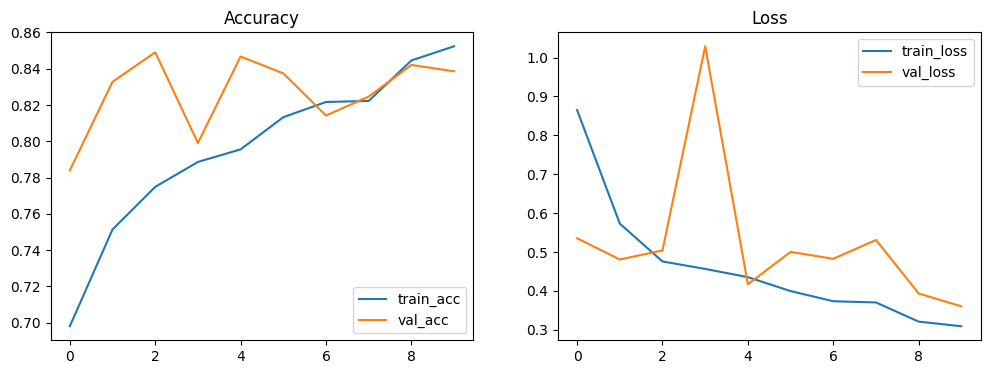

30/56 ━━━━━━━━━━━━━━━━━━━━ 2:54 7s/step - accuracy: 0.7375 - loss: 0.6486

In [ ]:
# 10) Save final model (already saved best via checkpoint)
binary_model.save(os.path.join(OUTPUT_DIR, "binary_cnn_last.h5"))
print("Saved models to", OUTPUT_DIR)

# 11) Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()

# 12) Evaluate on test set
# Load best model (safe)
best = load_model(checkpoint_path)
test_steps = int(np.ceil(test_flow.n / test_flow.batch_size))
loss, acc = best.evaluate(test_flow, steps=test_steps, verbose=1)
print(f"Test accuracy: {acc*100:.2f}%, test loss: {loss:.4f}")

# 13) Predictions -> confusion matrix and classification report
test_flow.reset()
y_prob = best.predict(test_flow, steps=test_steps, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_flow.classes  # keras flow_from_dataframe stores integer indices in .classes

# Map numeric indices to class labels
label_map = (train_flow.class_indices)  # e.g. {'benign':0,'malignant':1}
inv_label_map = {v:k for k,v in label_map.items()}
y_pred_labels = [inv_label_map[int(i)] for i in y_pred]
y_true_labels = [inv_label_map[int(i)] for i in y_true]

print("\nClassification Report (binary):")
print(classification_report(y_true_labels, y_pred_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(inv_label_map.values()))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(inv_label_map.values()), yticklabels=list(inv_label_map.values()))
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()



In [ ]:
!ls "/content/drive/MyDrive/models"


binary_cnn_best.h5  binary_cnn_last.h5


In [ ]:
from tensorflow.keras.models import load_model

checkpoint_path = "/content/drive/MyDrive/models/binary_cnn_best.h5"
best = load_model(checkpoint_path)
print("Model loaded!")


Model loaded!


In [ ]:
test_steps = int(np.ceil(test_flow.n / test_flow.batch_size))
loss, acc = best.evaluate(test_flow, steps=test_steps)
print(f"Test accuracy: {acc*100:.2f}%, Test loss: {loss:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 472s 9s/step - accuracy: 0.7762 - loss: 0.5683
Test accuracy: 81.01%, Test loss: 0.4903


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_flow.reset()
y_prob = best.predict(test_flow, steps=test_steps)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_flow.classes

label_map = test_flow.class_indices
inv_label_map = {v:k for k,v in label_map.items()}

y_pred_labels = [inv_label_map[i] for i in y_pred]
y_true_labels = [inv_label_map[i] for i in y_true]

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))


56/56 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step

Classification Report:
              precision    recall  f1-score   support

      benign       0.87      0.89      0.88      1417
   malignant       0.54      0.49      0.51       363

    accuracy                           0.81      1780
   macro avg       0.70      0.69      0.70      1780
weighted avg       0.80      0.81      0.81      1780



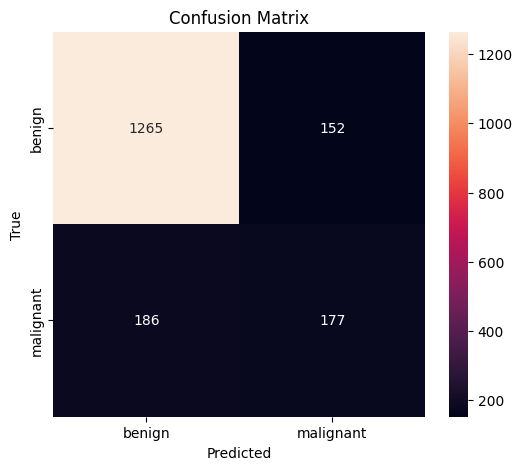

In [ ]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=list(inv_label_map.values()),
            yticklabels=list(inv_label_map.values()))
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 14) Inference: upload an image in Colab and predict
# Run the cell below and select an image file to upload. It will print predicted label and confidence.
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_single_image(model, img_path, target_size=(IMG_SIZE,IMG_SIZE)):
    img = load_img(img_path, target_size=target_size)
    arr = img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    prob = model.predict(arr)[0]
    idx = np.argmax(prob)
    label = inv_label_map[idx]
    return label, prob[idx], prob

print("To run inference: upload a file using files.upload()")
uploaded = files.upload()  # interactive: pick file(s)
for fn in uploaded.keys():
    label, conf, allprob = predict_single_image(best, fn)
    print(f"File: {fn}  -> Predicted: {label} ({conf*100:.2f}%)  probs: {allprob}")


To run inference: upload a file using files.upload()


Saving non.png to non.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
File: non.png  -> Predicted: malignant (83.94%)  probs: [0.16061084 0.8393891 ]
